In [2]:
import numpy as np
import os
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters
)

from sde.experiment_reports_owen import (
    PlotResults,
    sample_data
)

%load_ext autoreload
%autoreload 2



In [3]:
# notebook parameters
n_dimensions = 1
step_size = 1e-2
n_pts = 10000
n_subsample = 10

random_seed = 1


In [18]:
# network parameters
validation_split = .1
ARFF_validation_split = .1

drift_param = NNHyperparameters(K=2**7, 
                                M_min=10,
                                M_max=100,
                                lambda_reg=2e-3,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               lambda_reg=drift_param.lambda_reg,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diff')


In [19]:
# true functions parameters
def true_drift(x):
    result = -(4 * x**3 - 8 * x + 3) / 2
    return result.reshape(-1, 1)


def true_diffusion(x):
    result = (0.1 * x + 1) * 0.5
    return result.reshape(-1, 1)


def true_drift_diffusion(x):
    return true_drift(x), true_diffusion(x)


xlim = np.array([[-2, 2]])




h:  0.001
drift epoch: 30


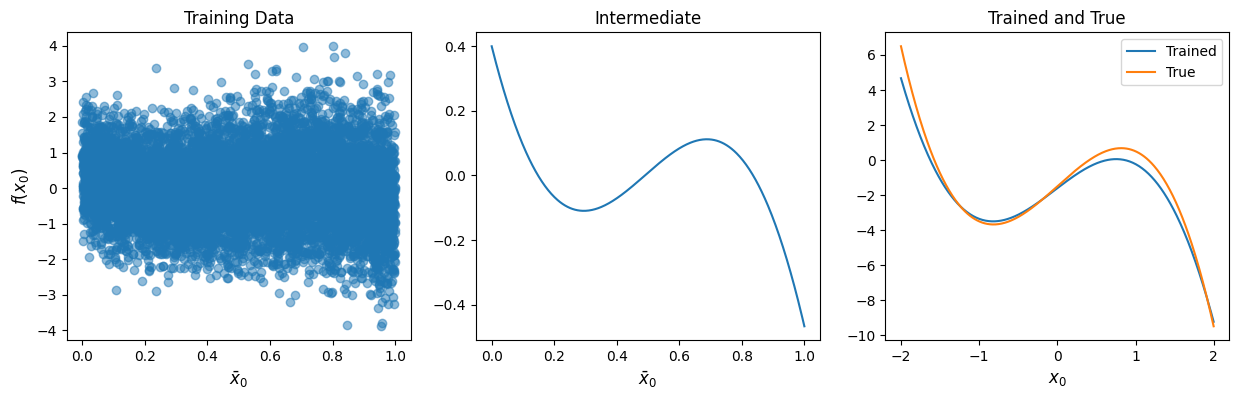

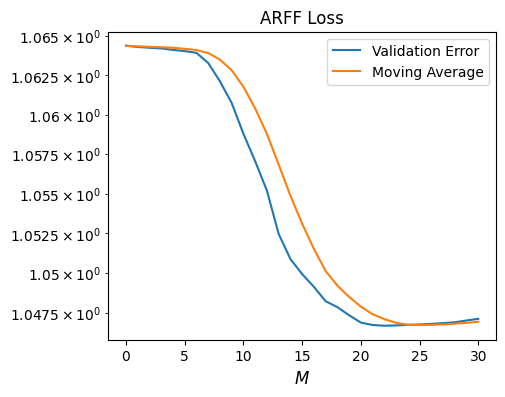

diff epoch: 10


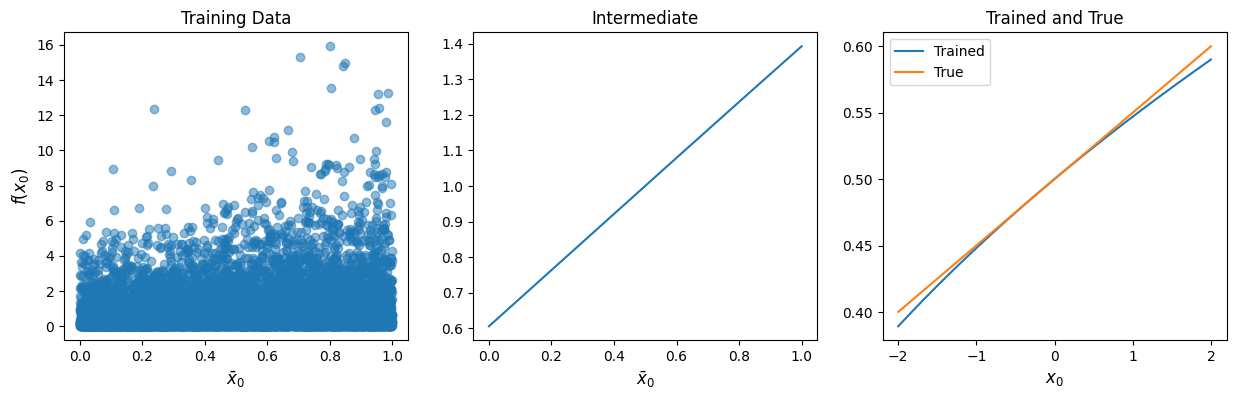

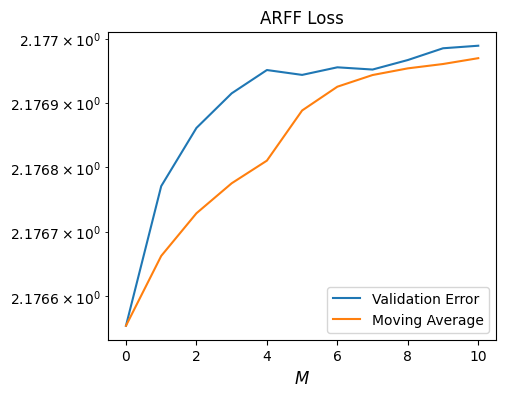

Drift RMSE: 0.5431039074938562
Diffusion RMSE: 0.004600946732766566
Observed loss: -2.741862274410636
Observed validation loss: -2.7658402974206147
True loss: -2.744977088936278
Training time: 3.6303303241729736
h:  0.0021544346900318843
drift epoch: 33


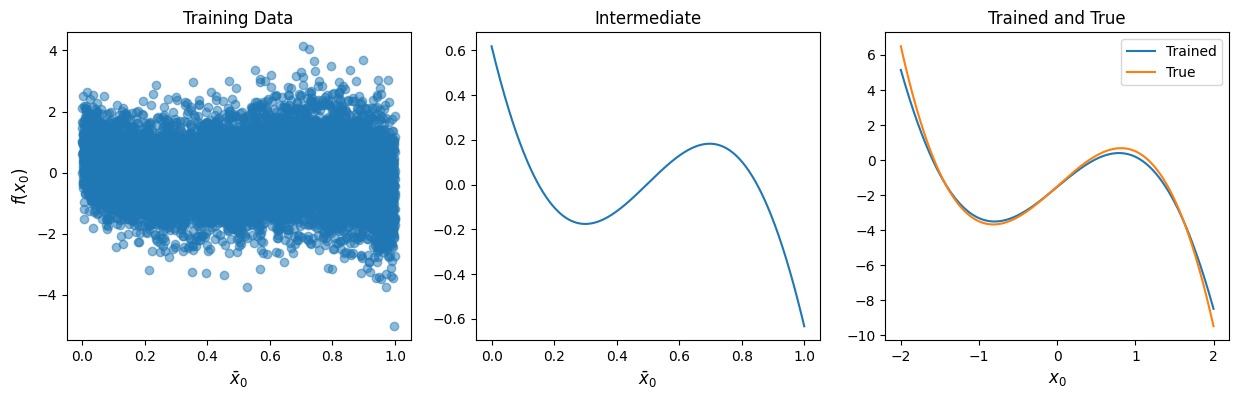

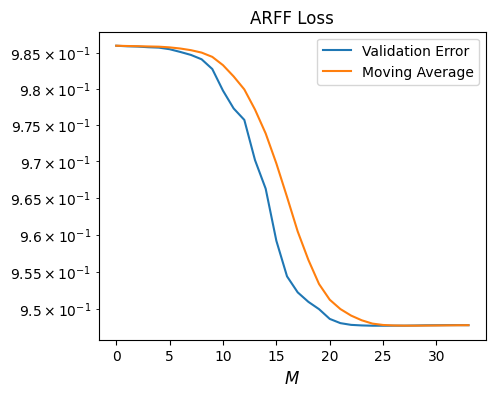

diff epoch: 18


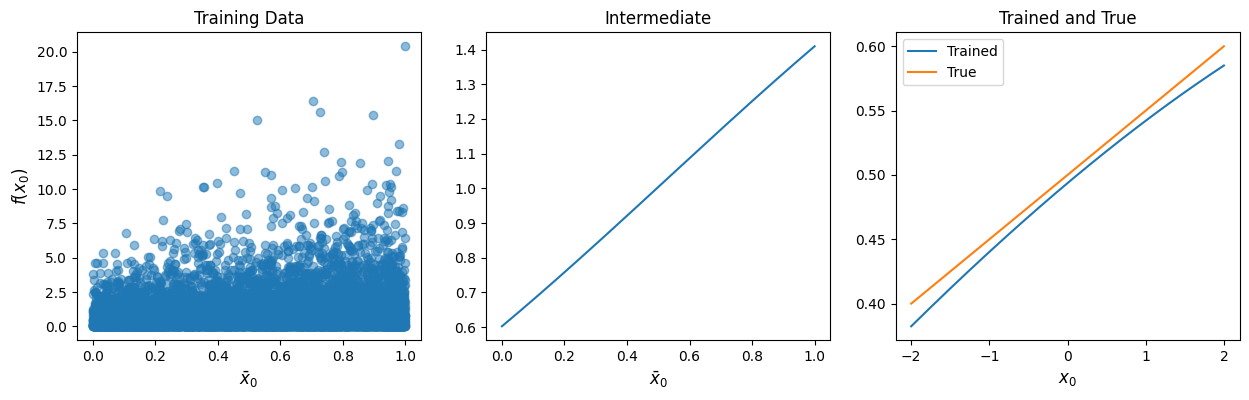

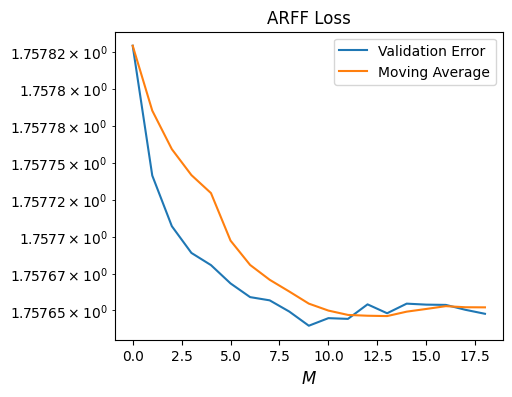

Drift RMSE: 0.3317203451617422
Diffusion RMSE: 0.01016282914560542
Observed loss: -2.373833833013491
Observed validation loss: -2.3555882868514346
True loss: -2.3122016855959515
Training time: 5.139825820922852
h:  0.004641588833612777
drift epoch: 33


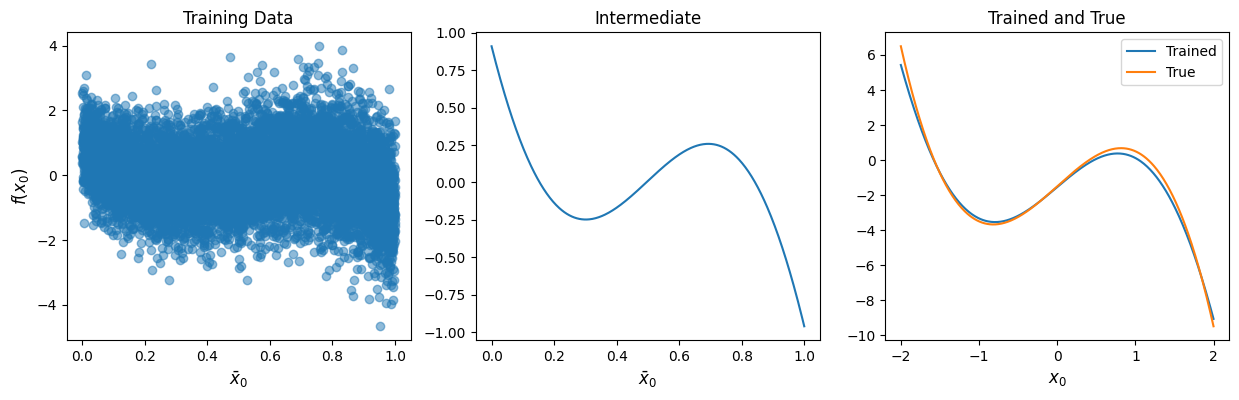

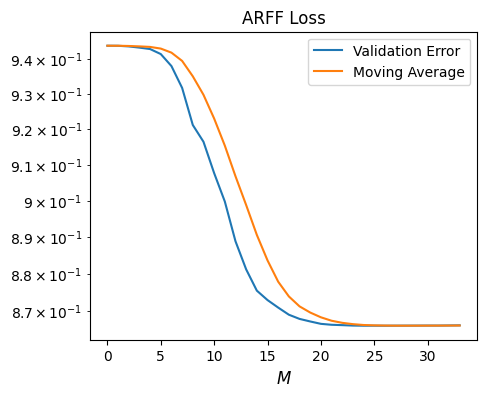

diff epoch: 10


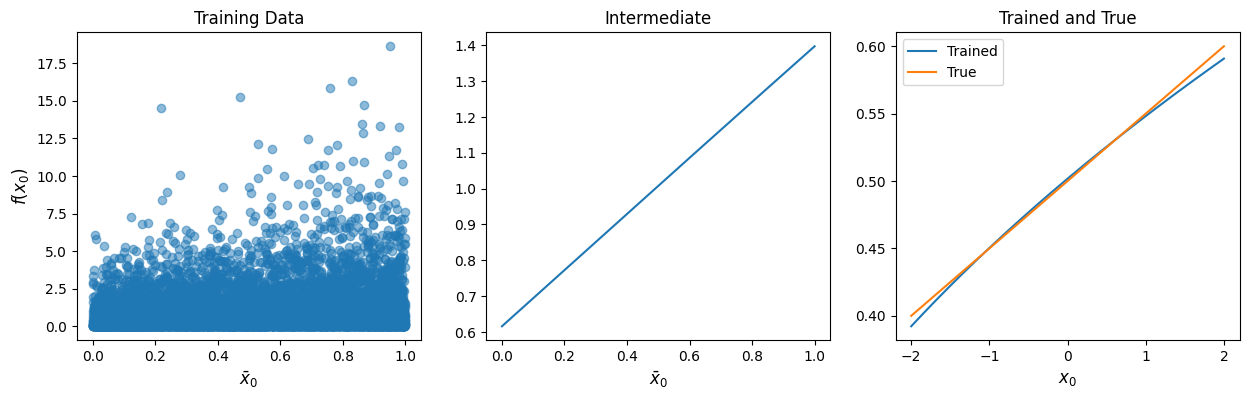

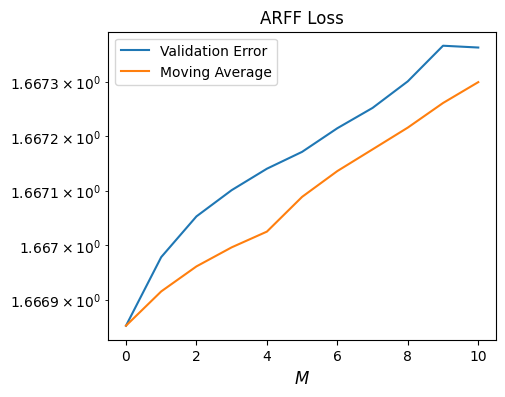

Drift RMSE: 0.2848726871419834
Diffusion RMSE: 0.003577504326558948
Observed loss: -1.9748522901673544
Observed validation loss: -2.01990367530399
True loss: -2.004769834638616
Training time: 4.215609550476074
h:  0.01
drift epoch: 36


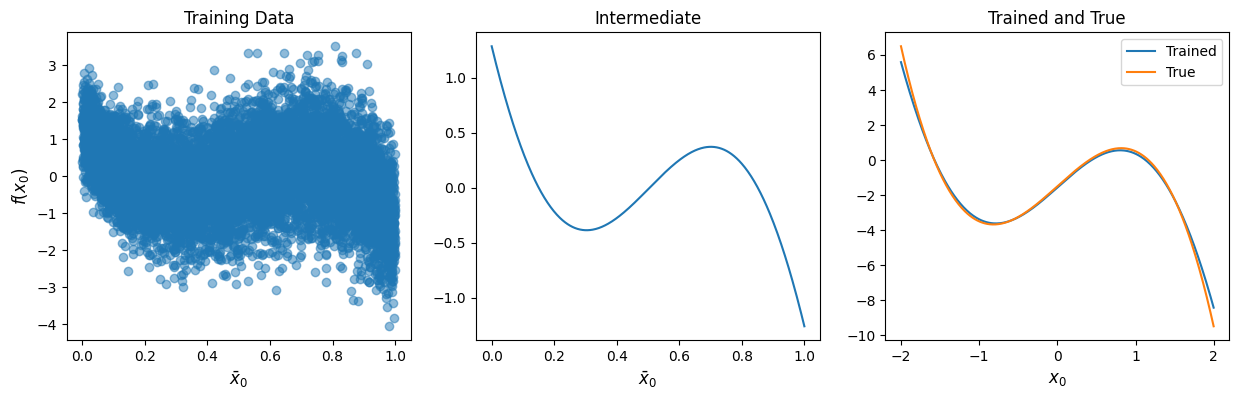

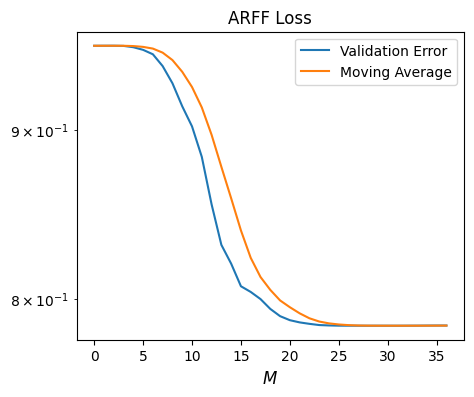

diff epoch: 21


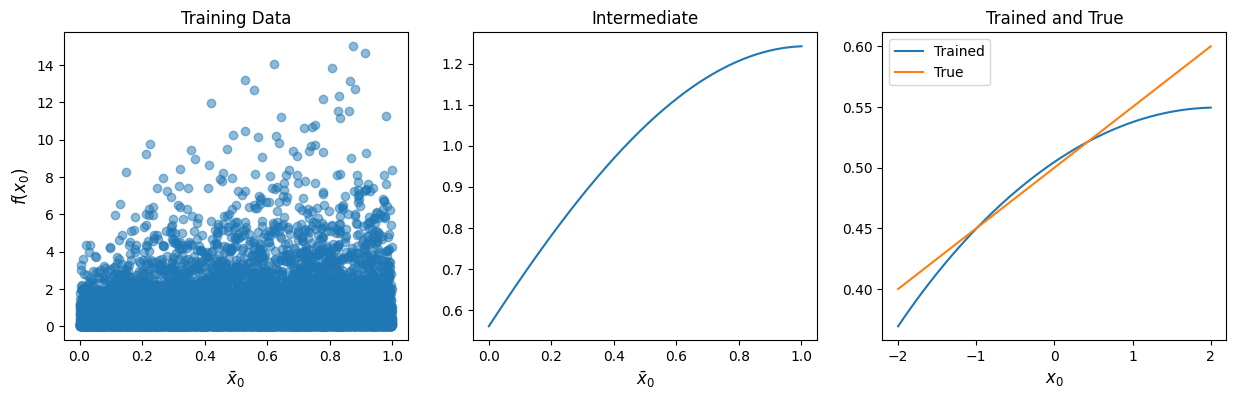

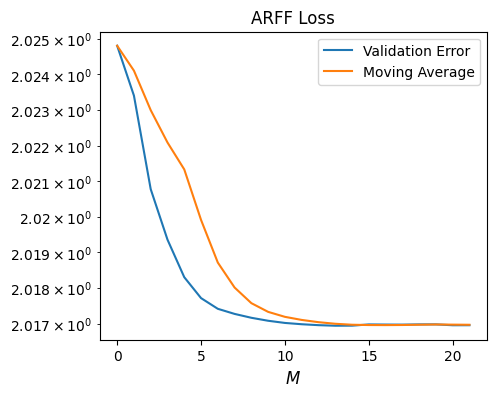

Drift RMSE: 0.24283806826897653
Diffusion RMSE: 0.018133321542991722
Observed loss: -1.6039374558394857
Observed validation loss: -1.5655491156960373
True loss: -1.5303170026783386
Training time: 6.358680248260498
h:  0.021544346900318832
drift epoch: 40


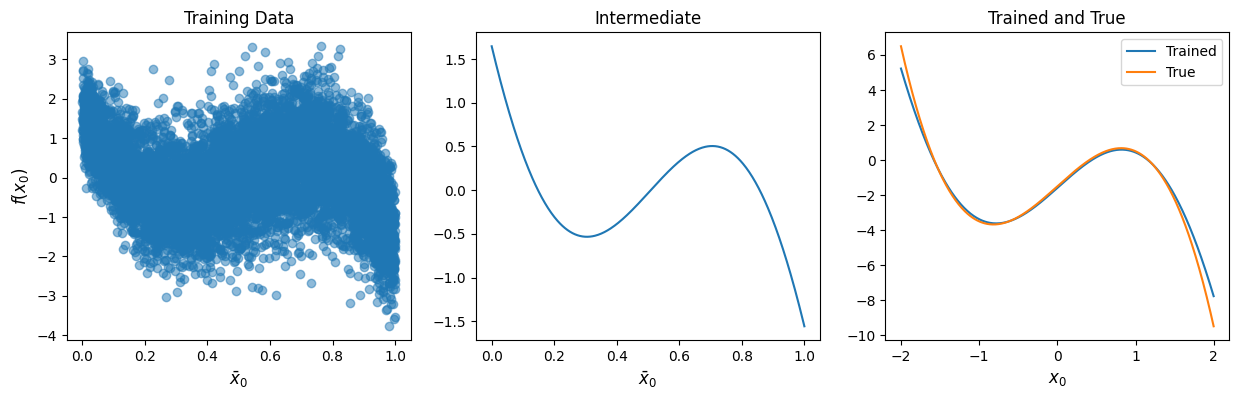

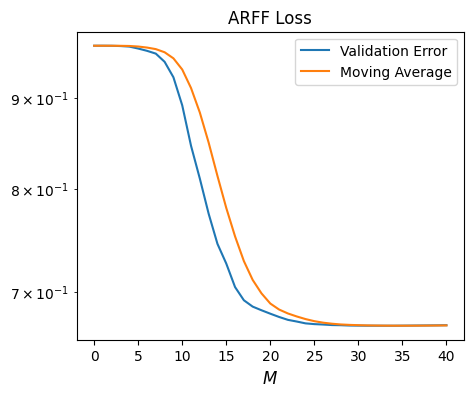

diff epoch: 16


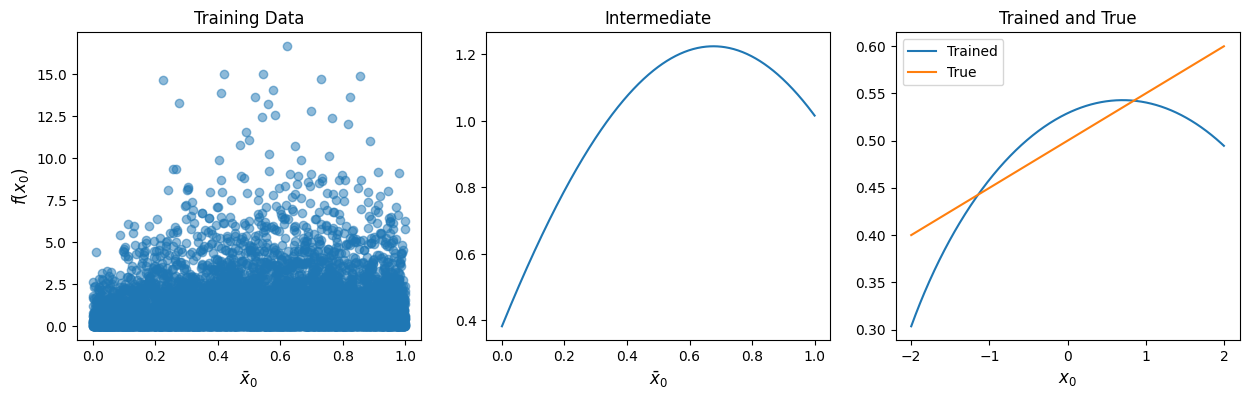

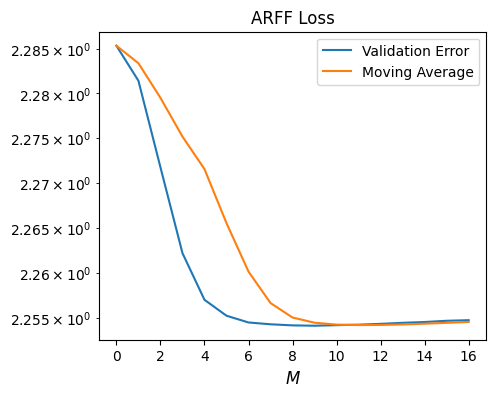

Drift RMSE: 0.4018980674957778
Diffusion RMSE: 0.04070740754351125
Observed loss: -1.2289873498234234
Observed validation loss: -1.2372309715787897
True loss: -1.2064177826687161
Training time: 6.543011903762817
h:  0.046415888336127774
drift epoch: 68


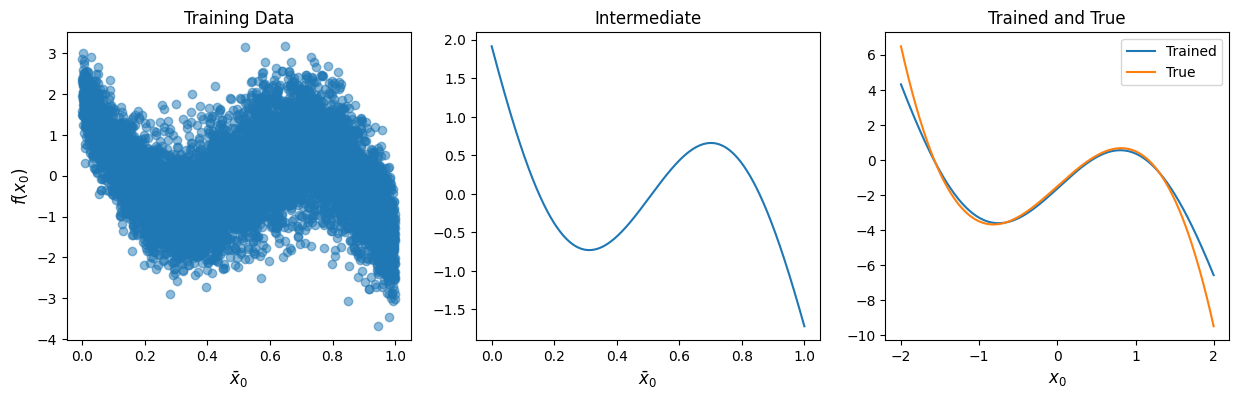

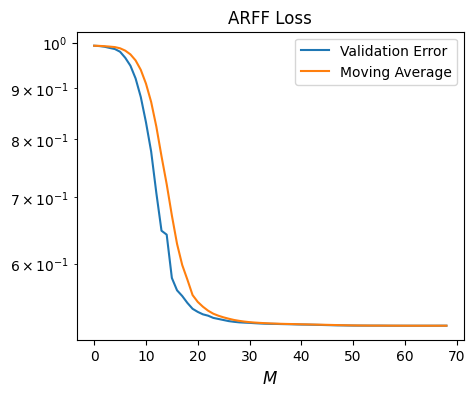

diff epoch: 13


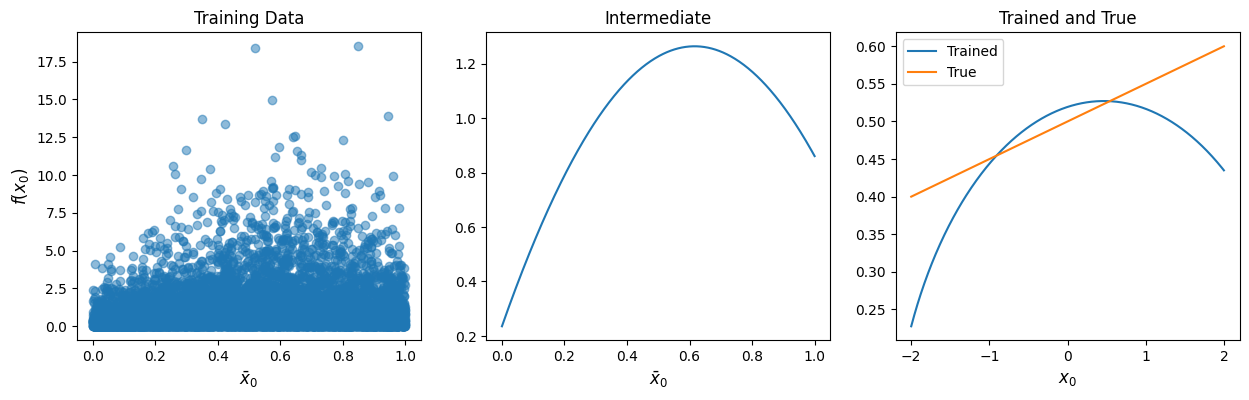

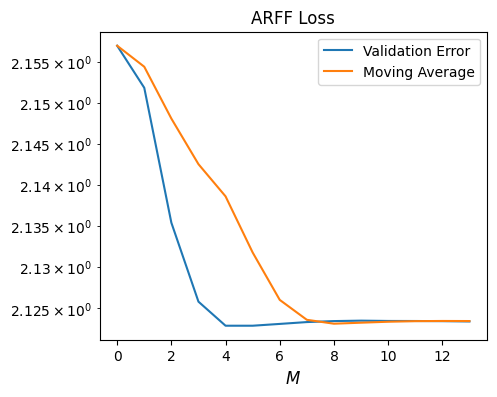

Drift RMSE: 0.6631414760947785
Diffusion RMSE: 0.066309925635284
Observed loss: -0.9006283051910092
Observed validation loss: -0.895061691692013
True loss: -0.7951713158619623
Training time: 9.848115921020508
h:  0.1
drift epoch: 69


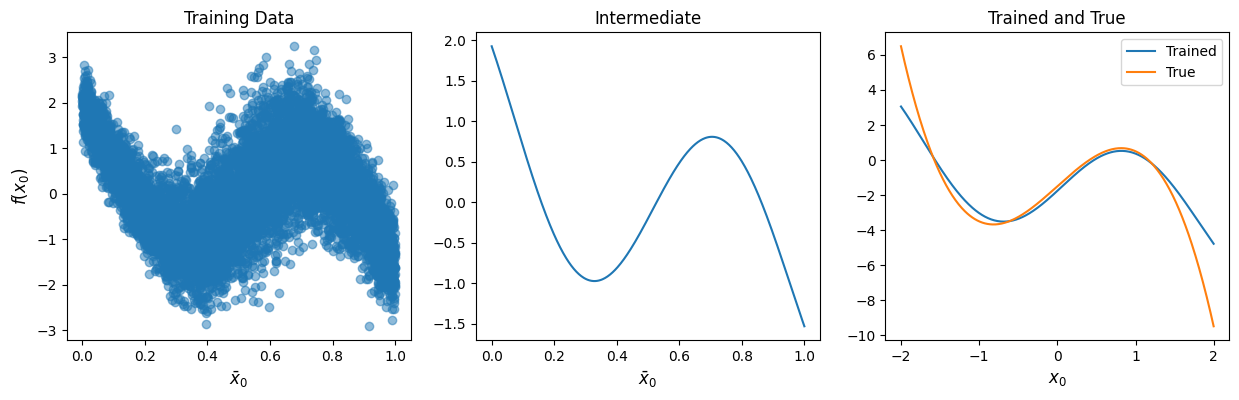

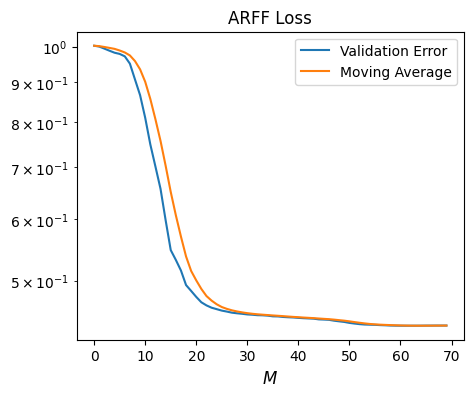

diff epoch: 99


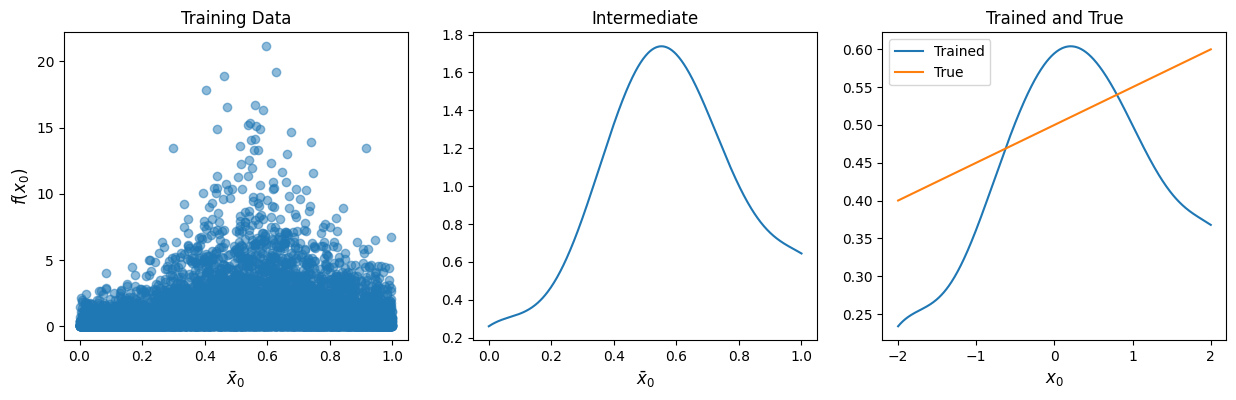

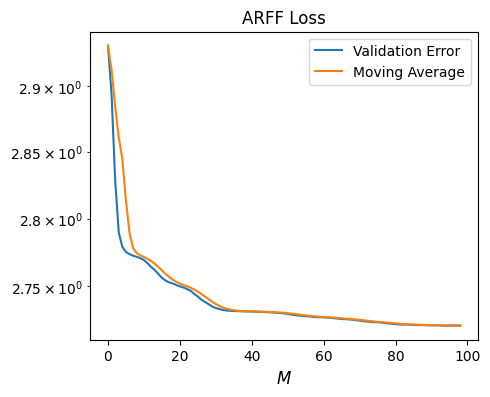

Drift RMSE: 1.0921234741659902
Diffusion RMSE: 0.11934785668917815
Observed loss: -0.5868533674381979
Observed validation loss: -0.6016935594214429
True loss: -0.2820665640583952
Training time: 24.567169666290283
h:  0.21544346900318823
drift epoch: 99


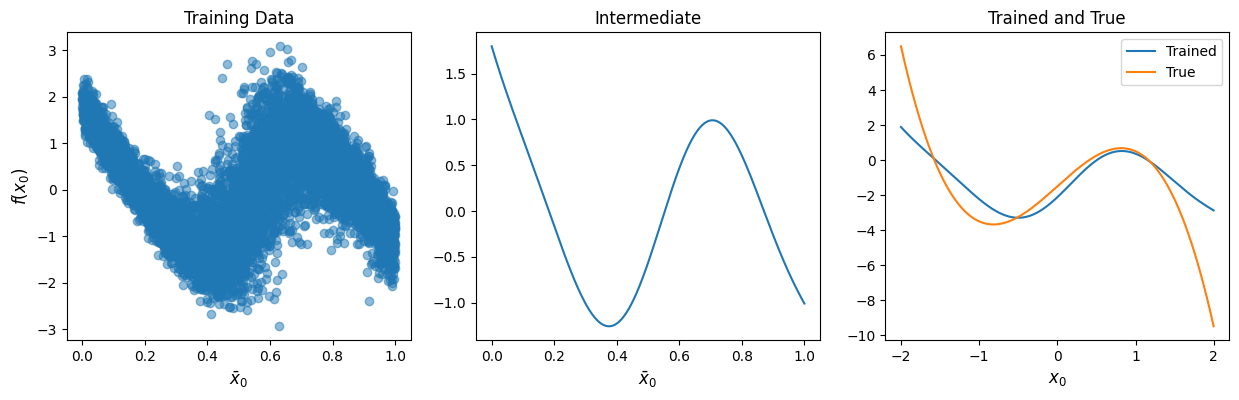

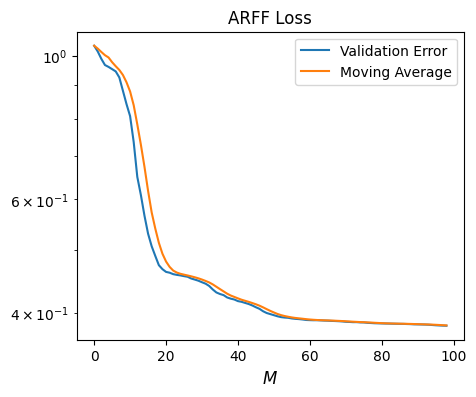

diff epoch: 99


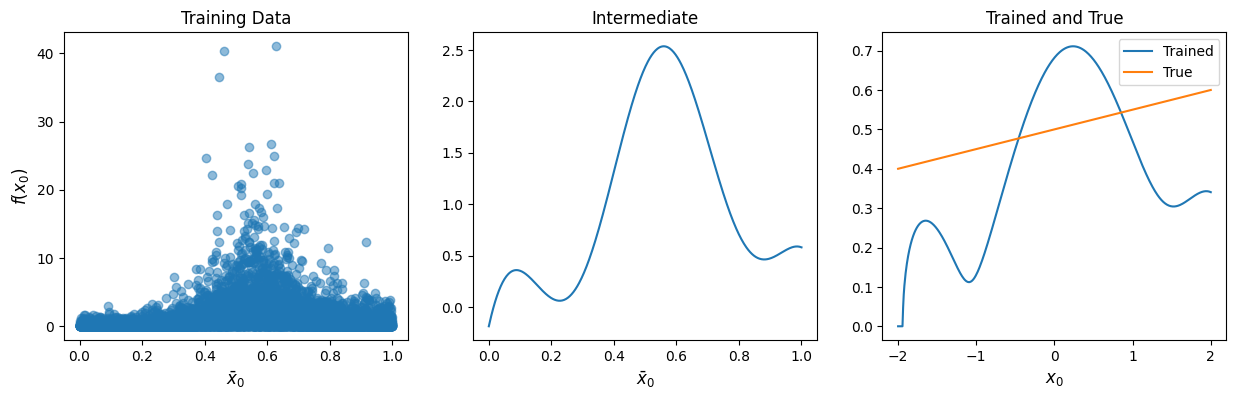

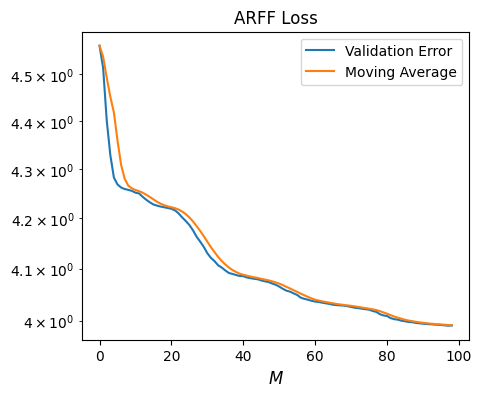

Drift RMSE: 1.642702360255402
Diffusion RMSE: 0.2039645234055913
Observed loss: 2451.140923212805
Observed validation loss: 2776.7594804459195
True loss: 0.9002099267107233
Training time: 31.209211111068726
h:  0.46415888336127775
drift epoch: 99


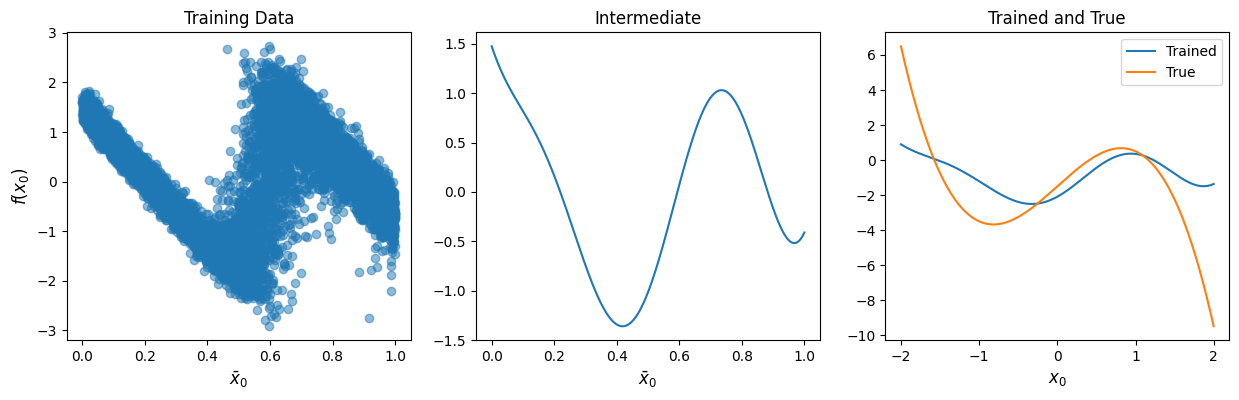

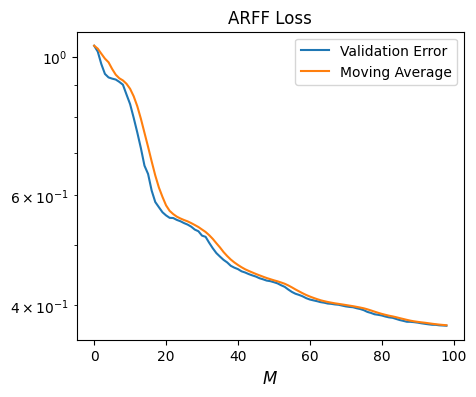

diff epoch: 99


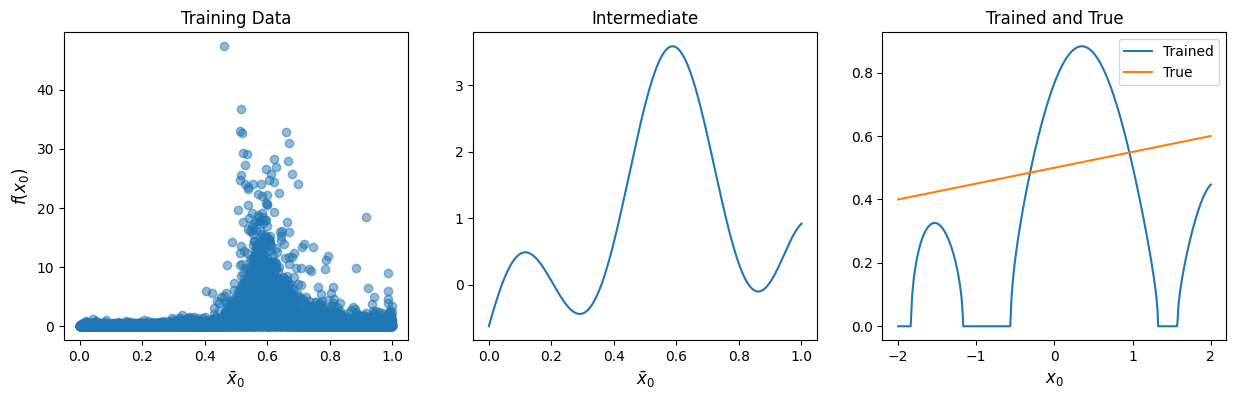

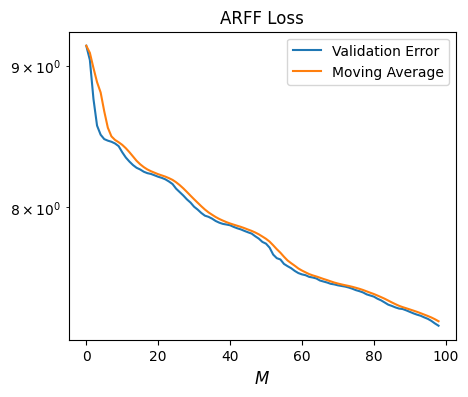

Drift RMSE: 2.1462291709292107
Diffusion RMSE: 0.3239480069646173
Observed loss: 47350.88688295
Observed validation loss: 58364.44313207317
True loss: 5.193567263273195
Training time: 30.982847929000854
h:  1.0
drift epoch: 99


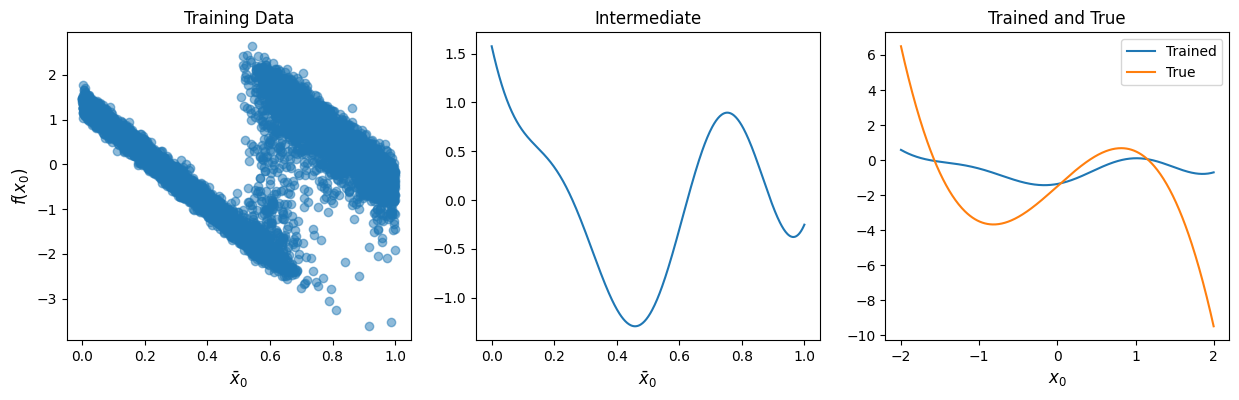

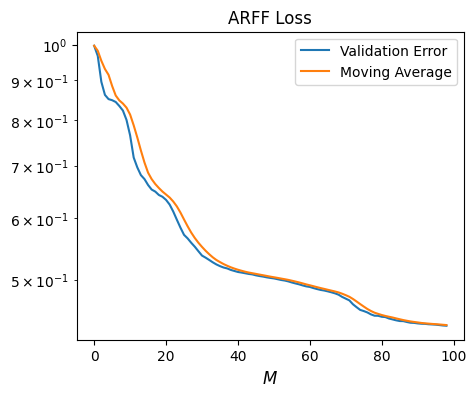

diff epoch: 99


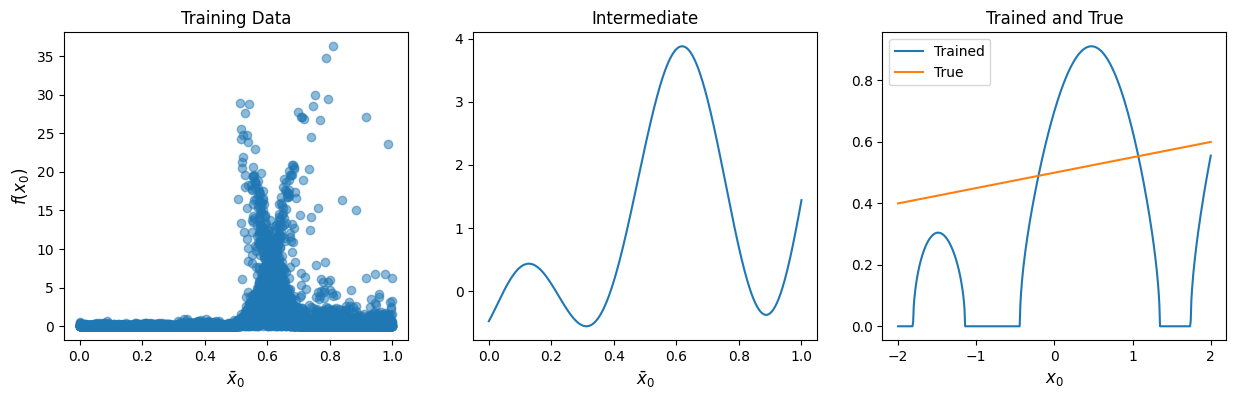

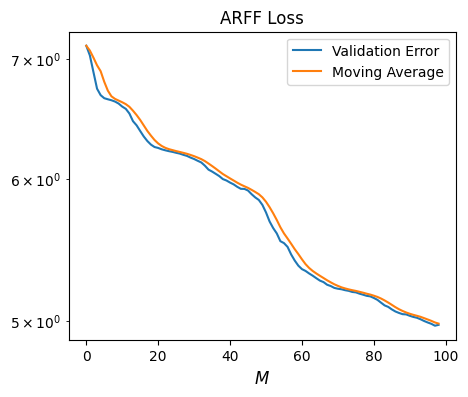

Drift RMSE: 2.5268615397172427
Diffusion RMSE: 0.3473837544703155
Observed loss: 51144.89707215917
Observed validation loss: 41906.28128386125
True loss: 14.574148075809145
Training time: 31.262887001037598


In [45]:
# train networks
No_of_tests = 1
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

step_size_test = 10 ** np.linspace(-3, 0, 10)
#step_size_test = [0.001, 0.01, 0.1, 1]
drift_RMSE = np.zeros(len(step_size_test))
diffusion_RMSE = np.zeros(len(step_size_test))

for j, step_size in enumerate(step_size_test):
    print('h: ', step_size)
    for i in range(No_of_tests):
        rng = np.random.default_rng(random_seed + i)
    
        # generate data
        n_subsample = int(1000 * step_size)
        x_data, y_data, _ = sample_data(true_drift_diffusion, step_size, n_pts, n_subsample, rng, xlim)
        step_sizes = np.zeros((n_pts, 1)) + step_size
        
        # build network
        SAT = SDEARFFTrain(n_dimensions=n_dimensions, rng=rng, resampling=True)
    
        # train network
        hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusion, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, plot=True)
        
        training_time[i] = hist.history["training_time"]
        val_loss[i] = hist.history["val_loss"]
    drift_RMSE[j] = hist.history["drift_RMSE"]
    diffusion_RMSE[j] = hist.history["diffusion_RMSE"]

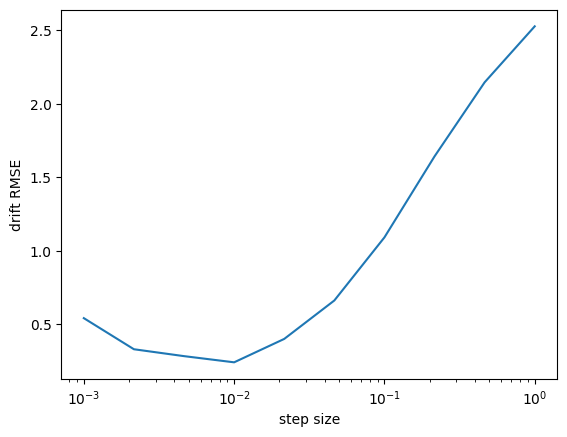

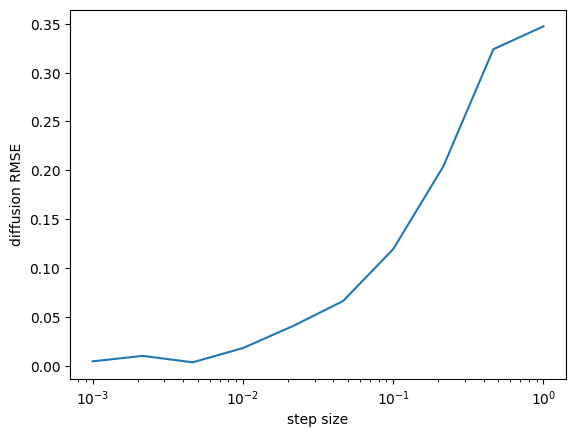

In [46]:
import matplotlib.pyplot as plt

plt.plot(step_size_test, drift_RMSE)
plt.xscale("log")
plt.xlabel('step size')
plt.ylabel('drift RMSE')
plt.show()

plt.plot(step_size_test, diffusion_RMSE)
plt.xscale("log")
plt.xlabel('step size')
plt.ylabel('diffusion RMSE')
plt.show()

Theoretical mean min loss: -1.5835419673390345
Loss standard deviation: 0.007453559924999299
Validation loss standard deviation: 0.022360679774997897


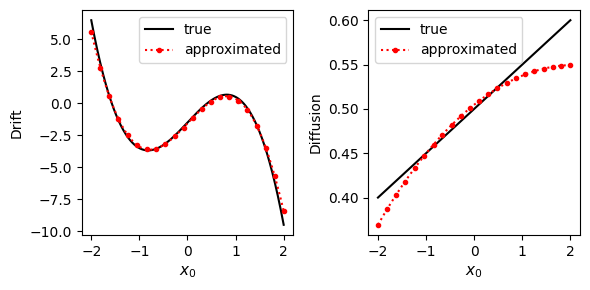

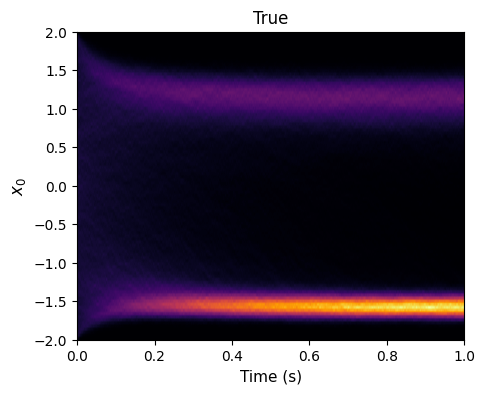

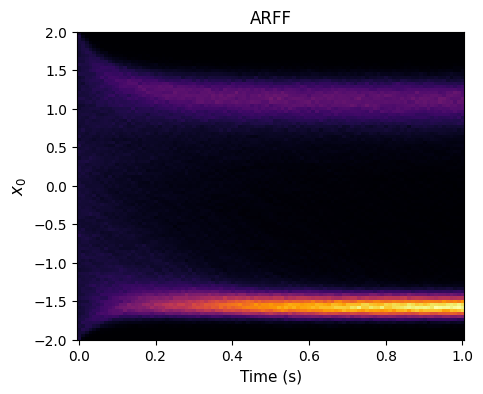

In [14]:
# display and save plots
PR = PlotResults(script_dir=script_dir, filename=filename, n_subsample=n_subsample)

# calculate theoretical mean min loss (integral over loss function across input domain)
PR.mean_min_loss(true_diffusion, n_pts, validation_split, step_size, xlim, save=False)

if No_of_tests > 1:
    PR.loss_stats(training_time, val_loss, save=False)

PR.plot_results_functions(SAT.drift_diffusion, true_drift_diffusion, x_data, save=False)

time = 100*step_size
PR.plot_histogram(true_drift_diffusion, step_size/n_subsample, time, rng, xlim, name='True', save=False)
PR.plot_histogram(SAT.drift_diffusion, step_size, time, rng, xlim, name='ARFF', save=False)
